<a href="https://colab.research.google.com/github/ashushekar/tensorflow-api/blob/master/DataExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q https://www-us.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
# !tar xf spark-3.0.1-bin-hadoop2.7.tgz
# !pip install -q findspark
# !pip install -q PyArrow >= 0.15.1
# !pip3 --no-cache-dir install seaborn==0.9.0

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

In [4]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [5]:
# spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
# spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [6]:
spark

In [7]:
import sys
import time

In [8]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import Window
from pyspark.sql.functions import pandas_udf, PandasUDFType

In [23]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import multivariate_normal
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_fscore_support as prfs
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from scipy.stats import multivariate_normal
from sklearn import metrics
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [10]:
import pandas as pd
import numpy as np
from collections import defaultdict

In [11]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [12]:
from IPython.display import display
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
from plotly import tools, figure_factory
# import qgrid

init_notebook_mode(connected=True)

In [13]:
config = {"toImageButtonOptions": {"width": None, "height": None}}

def buildFontLayout(inFontSize=18):
    return dict(size=inFontSize)

def builtLayout(xTitle, yTitle, plotTitle, inFontSize=18):
    layout = go.Layout(xaxis=dict(title = xTitle), 
                       yaxis=dict(title = yTitle),
                       title = plotTitle,
                       font = buildFontLayout(inFontSize),
                       showlegend=True)
    return layout
    

In [14]:
FILE_PATH = 'gdrive/My Drive/Colab Notebooks/transactions.csv'

dfTmp_transactions_data = spark.read.csv(FILE_PATH, 
                                         header=True, sep=',')

# dfTmp_transactions_data = dfTmp_transactions_data.withColumn("Date", 
#                           F.date_format(F.to_date(F.unix_timestamp(dfTmp_transactions_data.Date, 
#                                                                    "yymmdd").cast("timestamp")), 
#                                         'yyyy-MM-dd'))

# dfTmp_transactions_data = dfTmp_transactions_data.withColumn("Time", 
#                           F.date_format(F.to_timestamp(F.unix_timestamp(dfTmp_transactions_data.Time, 
#                                                                    "HHmm").cast("timestamp")), 
#                                         'HH:mm'))

# dfTmp_transactions_data = dfTmp_transactions_data.withColumn('Timestamp', 
#                                                              F.concat(F.col('Date'), 
#                                                                       F.lit(' '), 
#                                                                       F.col('Time')))
# print(dfTmp_transactions_data.agg(F.min('Date'), F.max('Date')).show())
# drop_columns = ['Date', 'Time']
# dfTmp_transactions_data = dfTmp_transactions_data.drop(*drop_columns)
dfTmp_transactions_data.dropDuplicates()

dfTmp_transactions_data.show(10)

+---+--------+--------+-----------+------+----+-----+--------+------+----+
|_c0|  Sender|Receiver|Beneficiary|  Date|Time| Type|Currency| Value|Flag|
+---+--------+--------+-----------+------+----+-----+--------+------+----+
|  0|AFGTDEXX|DZQYCXXX|   DZQYCXXX|190101|1058|MT202|     NOK| 30730|   0|
|  1|AFGTDEXX|IXQWBTXX|   GFJCCXXX|190101|1106|MT103|     BRL|164550|   0|
|  2|AFGTDEXX|HBRVDEXX|   HBRVDEXX|190101|1109|MT202|     HKD|336442|   0|
|  3|AFGTDEXX|IXQWBTXX|   NNMETOXX|190101|1116|MT103|     BYN| 26777|   0|
|  4|AFGTDEXX|QEYFCLXX|   QEYFCLXX|190101|1122|MT103|     UYI| 84396|   0|
|  5|AFGTDEXX|IXQWBTXX|   OTANCXXX|190101|1127|MT103|     BYN| 32691|   0|
|  6|AFGTDEXX|HPCKDEXX|   HPCKDEXX|190101|1134|MT202|     HKD|560953|   0|
|  7|AFGTDEXX|GILMDEXX|   XWZJCLXX|190101|1135|MT202|     UYI|179903|   0|
|  8|AFGTDEXX|KQPVNAXX|   WITJAOXX|190101|1137|MT202|     BRL|876850|   0|
|  9|AFGTDEXX|WTVRNEXX|   VMBACXXX|190101|1138|MT202|     EUR|126305|   0|
+---+--------+--------+--

In [15]:
# dfTmp_transactions_data.groupBy('Type', 'Flag').count().orderBy('Type').show()
# +------+----+--------+
# |  Type|Flag|   count|
# +------+----+--------+
# | MT103|   1|   79914|
# | MT103|   0|27024948|
# | MT202|   1|   19908|
# | MT202|   0|13900033|
# |MT202C|   0| 4708331|
# +------+----+--------+

In [16]:
dfTmp_d190101 = dfTmp_transactions_data.filter(dfTmp_transactions_data.Date == '190129')

In [17]:
dfTmp_d190101.show(10)

+----+--------+--------+-----------+------+----+------+--------+------+----+
| _c0|  Sender|Receiver|Beneficiary|  Date|Time|  Type|Currency| Value|Flag|
+----+--------+--------+-----------+------+----+------+--------+------+----+
|3287|AFGTDEXX|IXQWBTXX|   ASMDBTXX|190129| 915|MT202C|     BRL| 98372|   0|
|3288|AFGTDEXX|IXQWBTXX|   BDRQBTXX|190129| 916| MT103|     BRL| 84023|   0|
|3289|AFGTDEXX|MBXOBZXX|   HPCKDEXX|190129|1029| MT202|     HKD|233222|   0|
|3290|AFGTDEXX|WTVRNEXX|   HPCKDEXX|190129|1054| MT103|     EUR|186373|   0|
|3291|AFGTDEXX|FKUTPGXX|   OTANCXXX|190129|1105| MT202|     BYN| 62600|   0|
|3292|AFGTDEXX|IMYTIOXX|   IMYTIOXX|190129|1106| MT103|     HKD| 88915|   0|
|3293|AFGTDEXX|FHEVMHXX|   FHEVMHXX|190129|1115| MT202|     BRL|114992|   0|
|3294|AFGTDEXX|MYCRDEXX|   MYCRDEXX|190129|1116| MT202|     BRL|178912|   0|
|3295|AFGTDEXX|LXYPIEXX|   QEYFCLXX|190129|1117| MT103|     EUR| 34567|   0|
|3296|AFGTDEXX|IXQWBTXX|   WCMUAOXX|190129|1119| MT202|     BYN|249322|   0|

In [18]:
dfTmp_d190101.count()

174016

In [19]:
dfTmp_d190101_pd = dfTmp_d190101.toPandas()
dfTmp_d190101_pd['period'] = pd.to_datetime(dfTmp_d190101_pd["Date"] + '_' + dfTmp_d190101_pd["Time"], 
                                            format='%y%m%d_%H%M')
dfTmp_d190101_pd = dfTmp_d190101_pd.sort_values(by='period').reset_index()

In [33]:
# Exploring the dataset
df = dfTmp_d190101_pd[['Sender', 'Receiver', 'Beneficiary', 'Type', 'Currency', 'Value', 'Flag', 'period']]
df['Flag'] = pd.to_numeric(df['Flag'].values)
df['Value'] = pd.to_numeric(df['Value'].values)

print("Dataset is of shape: {}".format(df.shape))
print("Flagged cases: {}".format(len(df[df.Flag==1])))
print("Normal cases: {}".format(len(df[df.Flag==0])))
PercFlagged = np.round((float(len(df[df.Flag==1]))/len(df)), 4)
print("Contamination: {}".format(PercFlagged))
df.describe()

Dataset is of shape: (174016, 8)
Flagged cases: 394
Normal cases: 173622
Contamination: 0.0023


,Value,Flag
count,174016.00,174016.00
mean,370011.60,0.00
std,673729.09,0.05
min,9.00,0.00
25%,58331.00,0.00
50%,155660.00,0.00
75%,392346.75,0.00
max,22397986.00,1.00


In [34]:
# Encoding the variable
d = defaultdict(LabelEncoder)
fit = df[['Sender', 'Receiver', 'Beneficiary', 'Type', 'Currency', 'period']].apply(lambda x: d[x.name].fit_transform(x))

fit_copy = fit.copy()
fit['Class'] = df['Flag'].values
fit['Value'] = df['Value'].values

df = fit.copy()
df.head(5)

,Sender,Receiver,Beneficiary,Type,Currency,period,Class,Value
0,209,6565,4377,1,32,0,0,182212
1,222,897,1207,1,98,1,1,414200
2,1,9703,1069,2,13,2,0,534930
3,161,2155,108,1,35,3,0,108798
4,231,206,1528,1,17,4,0,333106


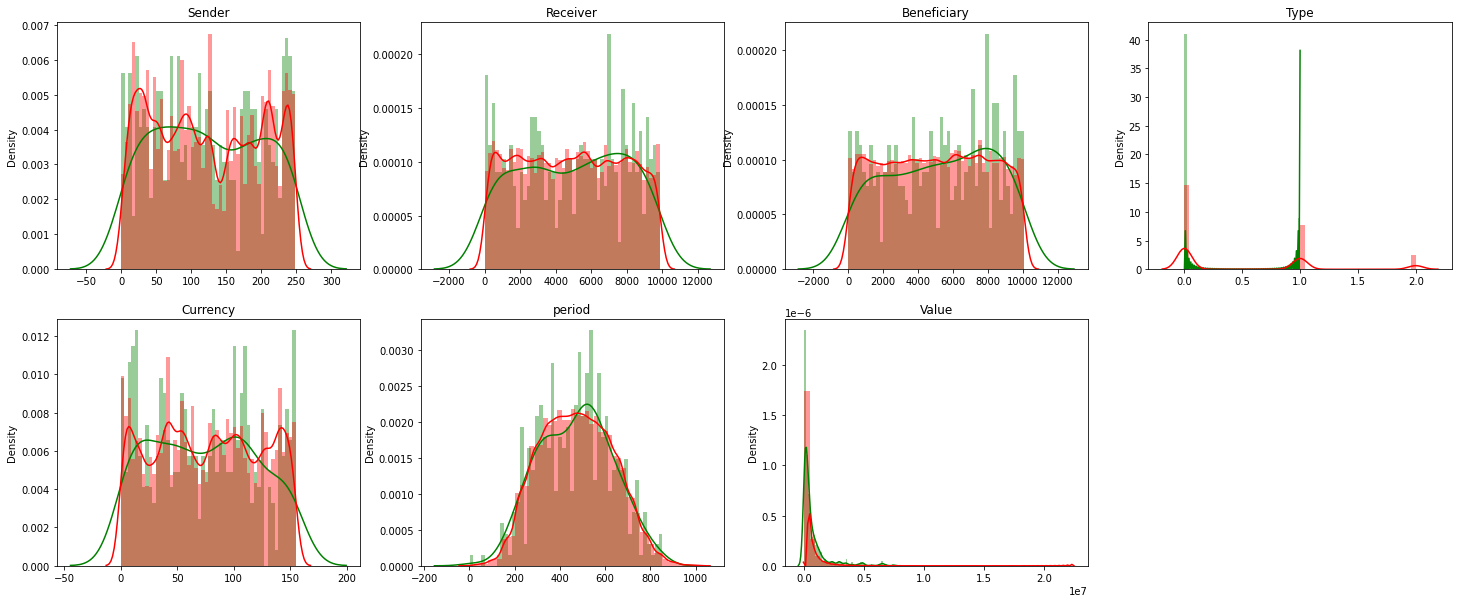

In [35]:
columns = df.drop('Class', axis=1).columns
grid = gridspec.GridSpec(2, 4)

plt.figure(figsize=(25, 10))

for n, col in enumerate(df[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(df[df.Class==1][col], bins=50, color='g')
    sns.distplot(df[df.Class==0][col], bins=50, color='r')
    ax.set_ylabel('Density')
    ax.set_title(str(col))
    ax.set_xlabel('')
    
plt.show()

In [36]:
normal_data = df[df.Class == 0]
flagged_data = df[df.Class == 1]

In [ ]:
print(len(normal_data))
print(len(flagged_data))

<Figure size 432x288 with 0 Axes>

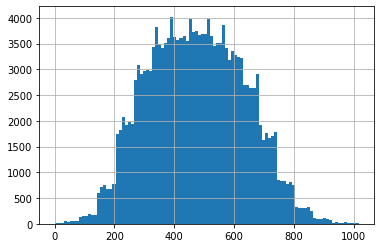

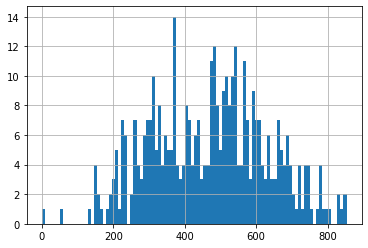

<Figure size 432x288 with 0 Axes>

In [37]:
normal_data['period'].hist(bins=100)
plt.figure()
flagged_data['period'].hist(bins=100)
plt.figure()

In [38]:
# Precision = percentage of flagged caught
# Recall = percentage of those caught that are actually Flagged
# F1 score = Harmonic mean of P & R
# Need to optimize on the hyperparamter of EPSILON

In [39]:
columns = df.drop('Class', axis=1).columns
normal = df[df.Class==0]
flagged = df[df.Class==1]
sample_size = len(flagged)
significant_features = []
critical_value = 2.58

def ztest(feature):
    mean = normal[feature].mean()
    std = flagged[feature].std()
    
    return (flagged[feature].mean() - mean) / (std/np.sqrt(sample_size))

for i in columns:
    z_value = ztest(i)
    
    if (abs(z_value) >= critical_value):
        print(i, "is statistically significant")
        significant_features.append(i)

Type is statistically significant
Value is statistically significant


In [40]:
significant_features.append('Class')
# df = df[significant_features]

In [41]:
significant_features

['Type', 'Value', 'Class']

In [42]:
df_norm = MinMaxScaler().fit_transform(df.iloc[:, :-1])
df_norm = pd.DataFrame(df_norm)
df_norm['Class'] = df['Class']
normal = df_norm.loc[df_norm['Class'] == 0, :]
flagged = df_norm.loc[df_norm['Class'] == 1, :]

In [43]:
df_norm.columns

Index([0, 1, 2, 3, 4, 5, 6, 'Class'], dtype='object')

In [44]:
# X = df_norm[[0, 1]]
X = df_norm[[0, 1, 2, 3, 4, 5, 6]]
y = df_norm['Class']
print(X.shape)
print(y.shape)

(174016, 7)
(174016,)


In [45]:
df_norm['Class'].unique()

array([0, 1])

## Modelling

In [46]:
classifiers = {
    "ISOLATION FOREST": IsolationForest(n_estimators=155, max_samples=len(X), contamination=PercFlagged, random_state=42, verbose=0),
    "LOCAL OUTLIER FACTOR": LocalOutlierFactor(n_neighbors=200, algorithm='auto', leaf_size=230, metric='euclidean', p=1, metric_params=None, contamination=PercFlagged),
    "ONE CLASS SVM": OneClassSVM(kernel='rbf', degree=3, gamma='auto', nu=PercFlagged, max_iter=-1)
}

In [47]:
for i, (clf_name, clf) in enumerate(classifiers.items()):
  # fit the data and tag outliers
  if clf_name == "LOCAL OUTLIER FACTOR":
    y_pred = clf.fit_predict(X)
    scores_prediction = clf.negative_outlier_factor_
  elif clf_name == "ONE CLASS SVM":
    clf.fit(X)
    y_pred = clf.predict(X)
  else:
    clf.fit(X)
    scores_prediction = clf.decision_function(X)
    y_pred = clf.predict(X)

  y_pred[y_pred == 1] = 0
  y_pred[y_pred == -1] = 1
  n_errors = (y_pred != y).sum()

  # run classification metrics
  print("{} number of errors: {}".format(clf_name, n_errors))
  print(pd.crosstab(y, y_pred))
  # print("Silhouette Coefficient: ", round(metrics.silhouette_score(df, y_pred, metric='euclidean'), 3))
  print("Adjusted Rand Index : ", round(metrics.adjusted_rand_score(y, y_pred), 3))
  print("Classification Report: ")
  print(classification_report(y, y_pred))


ISOLATION FOREST number of errors: 47
col_0       0    1
Class             
0      173595   27
1          20  374
Adjusted Rand Index :  0.94
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    173622
           1       0.93      0.95      0.94       394

    accuracy                           1.00    174016
   macro avg       0.97      0.97      0.97    174016
weighted avg       1.00      1.00      1.00    174016

LOCAL OUTLIER FACTOR number of errors: 731
col_0       0    1
Class             
0      173253  369
1         362   32
Adjusted Rand Index :  0.078
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    173622
           1       0.08      0.08      0.08       394

    accuracy                           1.00    174016
   macro avg       0.54      0.54      0.54    174016
weighted avg       1.00      1.00      1.00    174016

ONE CLAS

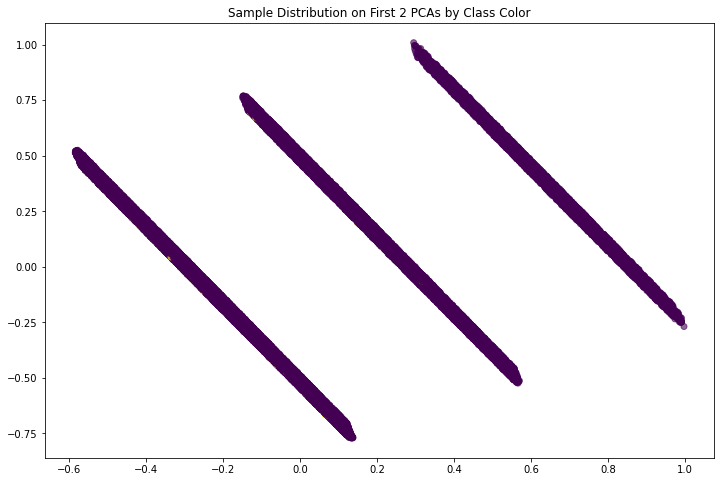

In [48]:
pca = PCA(2)
x_pca = pca.fit_transform(X)
x_pca = pd.DataFrame(x_pca)
x_pca.columns = ['pc1', 'pc2']

plt.figure(figsize=(12, 8))
plt.title('Sample Distribution on First 2 PCAs by Class Color')
plt.scatter(x_pca['pc1'], x_pca['pc2'], alpha=0.6, c=y)
plt.show()